# Load ULFxMAG and PC1xMAG CDF files

In [1]:
import io
import pathlib
import tempfile
import zipfile

import numpy as np
import pandas as pd
import pooch
import pycdfpp
import xarray as xr

## Download them

In [2]:
URL_ROOT = "swarm-diss.eo.esa.int/?do=download&file=swarm/"
DIRECTORY_ULF = "Level2daily/Latest_baselines/ULF/MAG/Sat_{spacecraft}/"
DIRECTORY_PC1 = "Level2daily/Latest_baselines/PC1/MAG/Sat_{spacecraft}/"
LOCAL_CACHE = "~/.swarm_cache"

In [3]:
def fetch_data(
    url_root=URL_ROOT,
    directory=DIRECTORY_ULF,
    spacecraft="A",
    filename=None,
    local_cache=LOCAL_CACHE,
):
    url_full = "https://" + str(
        pathlib.Path(url_root) / directory.format(spacecraft=spacecraft) / filename
    )
    local_path = pathlib.Path(local_cache).expanduser() / directory.format(
        spacecraft=spacecraft
    )
    path = pooch.retrieve(
        url=url_full,
        known_hash=None,
        fname=filename,
        path=local_path,
    )
    return path

In [4]:
ZIP_FILES = [
    fetch_data(
        directory=DIRECTORY_ULF,
        spacecraft="A",
        filename="SW_OPER_ULFAMAG_2F_20160101T000000_20160101T235959_0101.ZIP",
    ),
    fetch_data(
        directory=DIRECTORY_PC1,
        spacecraft="A",
        filename="SW_OPER_PC1AMAG_2F_20160101T000000_20160101T235959_0101.ZIP",
    ),
    fetch_data(
        directory=DIRECTORY_ULF,
        spacecraft="A",
        filename="SW_OPER_ULFAMAG_2F_20200101T000000_20200101T235959_0101.ZIP",
    ),
]

In [5]:
ZIP_FILES

['/home/ash/.swarm_cache/Level2daily/Latest_baselines/ULF/MAG/Sat_A/SW_OPER_ULFAMAG_2F_20160101T000000_20160101T235959_0101.ZIP',
 '/home/ash/.swarm_cache/Level2daily/Latest_baselines/PC1/MAG/Sat_A/SW_OPER_PC1AMAG_2F_20160101T000000_20160101T235959_0101.ZIP',
 '/home/ash/.swarm_cache/Level2daily/Latest_baselines/ULF/MAG/Sat_A/SW_OPER_ULFAMAG_2F_20200101T000000_20200101T235959_0101.ZIP']

## Load CDF

In [6]:
def load_cdf_from_zip(zip_file_path, cdf_handler=pycdfpp.load):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        file_list = zip_ref.namelist()
        filtered_files = [f for f in file_list if f.lower().endswith((".cdf", ".dbl"))]
        if len(filtered_files) == 0:
            raise FileNotFoundError("No CDF found")
        elif len(filtered_files) > 1:
            raise FileNotFoundError(f"Found multiple CDF: {filtered_files}")
        else:
            with zip_ref.open(filtered_files[0]) as file:
                return cdf_handler(file.read(), lazy_load=True)
                # with tempfile.NamedTemporaryFile() as temp_file:
                #     temp_file.write(file.read())
                #     return cdf_handler(temp_file.name)

In [7]:
TIMEVARS = {
    "ULFxMAG": {
        "": "Timestamp",
        "_e": "Timestamp_e",
        "_m": "Timestamp_m",
    },
    "PC1xMAG": {
        "_Bp": "Timestamp_Bp",
        "_m_Bp": "Timestamp_m_Bp",
        "_Ba": "Timestamp_Ba",
        "_m_Ba": "Timestamp_m_Ba",
        "_Br": "Timestamp_Br",
        "_m_Br": "Timestamp_m_Br",
    },
}


def cdf_to_xarray(cdf, product="ULFxMAG"):
    ds = xr.Dataset()
    timevars = TIMEVARS[product] if product in TIMEVARS.keys() else None
    for varname, data in cdf.items():
        if product == "ULFxMAG":
            timevar = timevars.get(varname[-2:], "Timestamp")
        elif product == "PC1xMAG":
            timevar = timevars.get(varname[-5:], timevars.get(varname[-3:]))
        else:
            timevar = "Timestamp"
        num_dims = len(data.shape)
        cdf_type = data.type
        dim_names = [timevar] + [f"{varname}_dim_{i}" for i in range(1, num_dims)]
        if str(cdf_type).endswith("CDF_EPOCH"):
            ds[varname] = dim_names, pycdfpp.to_datetime64(data)
        else:
            ds[varname] = dim_names, data
        attrs = {}
        for _, attr in dict(data.attributes).items():
            attrs[attr.name] = attr.value
        ds[varname].attrs = attrs
    return ds

## ULFxMAG

In [8]:
file = ZIP_FILES[2]
cdf = load_cdf_from_zip(file)
print(cdf)
ds = cdf_to_xarray(cdf, product="ULFxMAG")
ds

CDF:
  version: 3.8.1
  majority: row
  compression: None

Attributes:
  File_Name: "SW_OPER_ULFAMAG_2F_20200101T000000_20200101T235959_0101.cdf"
  File_Description: "ULF wave characterisation"
  Mission: "Swarm"
  File_Class: "OPER"
  File_Type: "ULFAMAG_2F"
  File_Version: "0101"
  Creator: [ [ "Swarm_ULFxMAG_processor", "0101" ] ]
  Created: "UTC=2024-03-23T00:48:37"
  Timespan: [ [ "UTC=2020-01-01T00:00:00", "UTC=2020-01-01T23:59:59" ] ]
  Producer: "EPSS"
  R_E: "6371.2 km"
  Field_Models: "CHAOS-7_v16"
  Input_Files: [ [ "SW_OPER_MAGA_LR_1B_20191231T000000_20191231T235959_0603_MDR_MAG_LR.cdf", "SW_OPER_MAGA_LR_1B_20200101T000000_20200101T235959_0603_MDR_MAG_LR.cdf", "SW_OPER_MAGA_LR_1B_20200102T000000_20200102T235959_0603_MDR_MAG_LR.cdf", "SW_OPER_MAGC_LR_1B_20191231T000000_20191231T235959_0603_MDR_MAG_LR.cdf", "SW_OPER_MAGC_LR_1B_20200101T000000_20200101T235959_0603_MDR_MAG_LR.cdf", "SW_OPER_MAGC_LR_1B_20200102T000000_20200102T235959_0603_MDR_MAG_LR.cdf", "SW_OPER_EFIA_LP_1B_201

<xarray.Dataset> Size: 2MB
Dimensions:             (Timestamp: 1440, Timestamp_e: 12178, Timestamp_m: 34)
Coordinates:
  * Timestamp           (Timestamp) datetime64[ns] 12kB 2020-01-01T00:00:30 ....
  * Timestamp_e         (Timestamp_e) datetime64[ns] 97kB 2020-01-01T02:26:20...
  * Timestamp_m         (Timestamp_m) datetime64[ns] 272B 2020-01-01T02:28:07...
Data variables: (12/60)
    Latitude            (Timestamp) float64 12kB 78.58 82.31 ... -46.6 -50.44
    Longitude           (Timestamp) float64 12kB 105.0 111.9 ... -86.38 -86.22
    Radius              (Timestamp) float64 12kB 6.803e+06 ... 6.82e+06
    Latitude_QD         (Timestamp) float64 12kB 73.7 77.13 ... -34.25 -37.9
    Longitude_QD        (Timestamp) float64 12kB 177.3 -40.07 ... -8.943 -7.989
    UT                  (Timestamp) float64 12kB 0.008333 0.02514 ... 23.99
    ...                  ...
    Power_m             (Timestamp_m) float64 272B -1.922 -2.761 ... -2.37
    Prominence_m        (Timestamp_m) float64 272B 1.025 1.21 ... 1.15 1.203
    EPB_m               (Timestamp_m) int8 34B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    FAC_m               (Timestamp_m) float64 272B 1.427 0.01024 ... nan 0.3694
    Flag_B_m            (Timestamp_m) uint8 34B 0 0 0 255 0 0 0 ... 0 0 0 0 0 0
    Quality_m           (Timestamp_m) int8 34B 0 0 0 0 0 2 0 2 ... 2 0 3 2 0 0 2

In [9]:
pd.DatetimeIndex(ds["Timestamp"]).is_monotonic_increasing

True

In [10]:
pd.DatetimeIndex(ds["Timestamp_e"]).is_monotonic_increasing

False

In [11]:
pd.DatetimeIndex(ds["Timestamp_m"]).is_monotonic_increasing

False

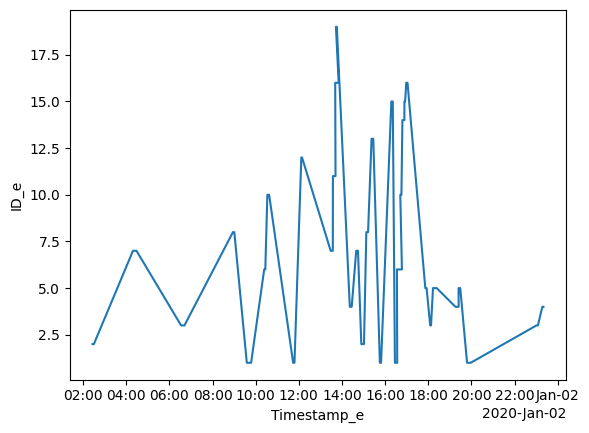

In [12]:
ds["ID_e"].plot()

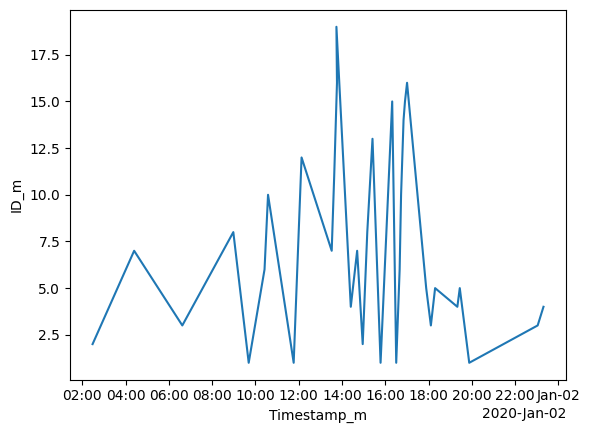

In [13]:
ds["ID_m"].plot()

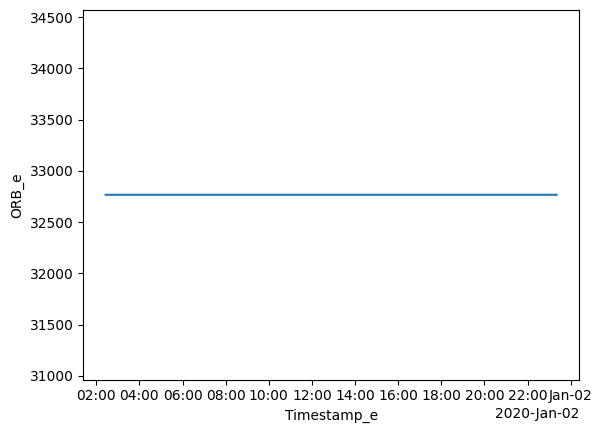

In [14]:
ds["ORB_e"].plot()

TBC find where ORB_e goes wrong (it is okay on 2016-01-01)

## PC1xMAG

In [20]:
file = ZIP_FILES[1]
cdf = load_cdf_from_zip(file)
print(cdf)
ds = cdf_to_xarray(cdf, product="PC1xMAG")
ds

CDF:
  version: 3.8.1
  majority: row
  compression: None

Attributes:
  File_Name: "SW_OPER_PC1AMAG_2F_20160101T000000_20160101T235959_0101.cdf"
  File_Description: "Pc1 wave characteriation"
  Mission: "Swarm"
  File_Class: "OPER"
  File_Type: "PC1AMAG_2F"
  File_Version: "0101"
  Creator: [ [ "Swarm_PC1xMAG_processor", "0101" ] ]
  Created: "UTC=2024-06-06T18:28:40"
  Timespan: [ [ "UTC=2016-01-01T00:00:00", "UTC=2016-01-01T23:59:59" ] ]
  R_E: "6371.2 km"
  Input_Files: [ [ "SW_OPER_MAGA_HR_1B_20160101T000000_20160101T235959_0602_MDR_MAG_HR.cdf", "SW_OPER_MAGA_HR_1B_20151231T000000_20151231T235959_0602_MDR_MAG_HR.cdf", "SW_OPER_AUXAORBCNT_20131122T132146_20240329T230703_0001.TXT" ] ]
  Producer: "EPSS"

Variables:
  ORB_Bp: [ 1 ], [CDF_UINT4], record vary:True, compression: GNU GZIP
  DIR_Bp: [ 1 ], [CDF_INT1], record vary:True, compression: GNU GZIP
  ID_Bp: [ 1 ], [CDF_UINT1], record vary:True, compression: GNU GZIP
  Timestamp_Bp: [ 1 ], [CDF_EPOCH], record vary:True, compressio

<xarray.Dataset> Size: 2kB
Dimensions:            (Timestamp_Bp: 1, Timestamp_m_Bp: 1, Timestamp_Ba: 15,
                        Timestamp_m_Ba: 2, Timestamp_Br: 1, Timestamp_m_Br: 1)
Coordinates:
  * Timestamp_Bp       (Timestamp_Bp) datetime64[ns] 8B 2000-01-01
  * Timestamp_m_Bp     (Timestamp_m_Bp) datetime64[ns] 8B 2000-01-01
  * Timestamp_Ba       (Timestamp_Ba) datetime64[ns] 120B 2016-01-01T02:11:17...
  * Timestamp_m_Ba     (Timestamp_m_Ba) datetime64[ns] 16B 2016-01-01T02:12:1...
  * Timestamp_Br       (Timestamp_Br) datetime64[ns] 8B 2000-01-01
  * Timestamp_m_Br     (Timestamp_m_Br) datetime64[ns] 8B 2000-01-01
Data variables: (12/105)
    ORB_Bp             (Timestamp_Bp) uint32 4B 0
    DIR_Bp             (Timestamp_Bp) int8 1B 0
    ID_Bp              (Timestamp_Bp) uint8 1B 0
    Latitude_Bp        (Timestamp_Bp) float64 8B nan
    Longitude_Bp       (Timestamp_Bp) float64 8B nan
    Radius_Bp          (Timestamp_Bp) float64 8B nan
    ...                 ...
    Freq_std_m_Br      (Timestamp_m_Br) float64 8B nan
    Halfwidth_m_Br     (Timestamp_m_Br) float64 8B nan
    Power_m_Br         (Timestamp_m_Br) float64 8B nan
    Prominence_m_Br    (Timestamp_m_Br) float64 8B nan
    ROFC_m_Br          (Timestamp_m_Br) float64 8B nan
    Quality_m_Br       (Timestamp_m_Br) uint8 1B 254

In [16]:
print(dict(cdf.attributes)["File_Name"])

for var in (
    "Timestamp_Bp",
    "Timestamp_m_Bp",
    "Timestamp_Ba",
    "Timestamp_m_Ba",
    "Timestamp_Br",
    "Timestamp_m_Br",
):
    # dict(cdf.items())[var]
    times = [
        t.isoformat()[:19]
        # for t in cdf_time_to_datetime(dict(cdf.items())[var].values["value"])
        for t in pycdfpp.to_datetime(dict(cdf.items())[var])
    ]
    print(f"{var}:\n{times}\n")

File_Name: "SW_OPER_PC1AMAG_2F_20160101T000000_20160101T235959_0101.cdf"

Timestamp_Bp:
['2000-01-01T00:00:00']

Timestamp_m_Bp:
['2000-01-01T00:00:00']

Timestamp_Ba:
['2016-01-01T02:11:17', '2016-01-01T02:11:32', '2016-01-01T02:11:47', '2016-01-01T02:12:02', '2016-01-01T02:12:17', '2016-01-01T02:12:32', '2016-01-01T02:12:47', '2016-01-01T02:13:02', '2016-01-01T02:13:17', '2016-01-01T04:31:16', '2016-01-01T04:31:31', '2016-01-01T04:31:46', '2016-01-01T04:32:01', '2016-01-01T04:32:16', '2016-01-01T04:32:31']

Timestamp_m_Ba:
['2016-01-01T02:12:17', '2016-01-01T04:31:54']

Timestamp_Br:
['2000-01-01T00:00:00']

Timestamp_m_Br:
['2000-01-01T00:00:00']



### Modify the CDF to store a version with empty arrays

In [17]:
pycdfpp.save(cdf, "SW_OPER_PC1AMAG_2F_20160101T000000_20160101T235959_0101.cdf")

True

In [18]:
# null_time = np.void((63113904000000.0,), dtype=[("value", "<f8")])
for varname, cdfvar in cdf.items():
    if len(cdfvar) == 1:
        cdfvar.set_values(
            np.array([], dtype=cdfvar.values.dtype),
            cdfvar.type,
        )
pycdfpp.save(
    cdf, "SW_OPER_PC1AMAG_2F_20160101T000000_20160101T235959_0101_modified.cdf"
)

[] DataType.CDF_UINT4
[] DataType.CDF_INT1
[] DataType.CDF_UINT1
[] DataType.CDF_EPOCH
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_UINT1
[] DataType.CDF_UINT1
[] DataType.CDF_UINT1
[] DataType.CDF_UINT4
[] DataType.CDF_INT1
[] DataType.CDF_UINT1
[] DataType.CDF_EPOCH
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_UINT1
[] DataType.CDF_UINT4
[] DataType.CDF_INT1
[] DataType.CDF_UINT1
[] DataType.CDF_EPOCH
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] DataType.CDF_DOUBLE
[] Data

True

In [19]:
pycdfpp.load("SW_OPER_PC1AMAG_2F_20160101T000000_20160101T235959_0101_modified.cdf")

CDF:
  version: 3.8.0
  majority: row
  compression: None

Attributes:
  File_Name: "SW_OPER_PC1AMAG_2F_20160101T000000_20160101T235959_0101.cdf"
  File_Description: "Pc1 wave characteriation"
  Mission: "Swarm"
  File_Class: "OPER"
  File_Type: "PC1AMAG_2F"
  File_Version: "0101"
  Creator: [ [ "Swarm_PC1xMAG_processor", "0101" ] ]
  Created: "UTC=2024-06-06T18:28:40"
  Timespan: [ [ "UTC=2016-01-01T00:00:00", "UTC=2016-01-01T23:59:59" ] ]
  R_E: "6371.2 km"
  Input_Files: [ [ "SW_OPER_MAGA_HR_1B_20160101T000000_20160101T235959_0602_MDR_MAG_HR.cdf", "SW_OPER_MAGA_HR_1B_20151231T000000_20151231T235959_0602_MDR_MAG_HR.cdf", "SW_OPER_AUXAORBCNT_20131122T132146_20240329T230703_0001.TXT" ] ]
  Producer: "EPSS"

Variables:
  ORB_Bp: [ 0 ], [CDF_UINT4], record vary:True, compression: Unknown
  DIR_Bp: [ 0 ], [CDF_INT1], record vary:True, compression: Unknown
  ID_Bp: [ 0 ], [CDF_UINT1], record vary:True, compression: Unknown
  Timestamp_Bp: [ 0 ], [CDF_EPOCH], record vary:True, compression: 